# Fit a Gaussian profile to lines with MCMC

In the last notebook we explored the data through quantifying **line strengths** by eye.  In this notebook we will use a probabilistic computational technique called [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to fit a Gaussian to spectral lines in HPF data.  The area under the curve of the Gaussian will then represent the line line strength.

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

In [42]:
goldilocks_files = glob.glob('../data/HPF/Helium-transit-data/**/Goldilocks*.fits', recursive=True)

In [43]:
def get_goldilocks_dataframe(fn):
    """Return a pandas Dataframe given a Goldilocks FITS file name"""
    hdus = fits.open(fn)
    df_original = pd.DataFrame()
    for j in range(28):
        df = pd.DataFrame()
        for i in range(1, 10):
            name = hdus[i].name
            df[name] = hdus[i].data[j, :]
        df['order'] = j
        df_original = df_original.append(df, ignore_index=True)
    keep_mask = df_original[df_original.columns[0:6]] != 0.0
    df_original = df_original[keep_mask.all(axis=1)].reset_index(drop=True)
    
    return df_original

In [44]:
index = 129 # Pick a number in the range (0,410]
fn = goldilocks_files[index]

In [85]:
print(fn)

../data/HPF/Helium-transit-data\HAT-P-32b\out-of-transit\20200807\Goldilocks_20200807T091125_v1.0_0037.spectra.fits


In [45]:
%time df = get_goldilocks_dataframe(fn)

Wall time: 397 ms


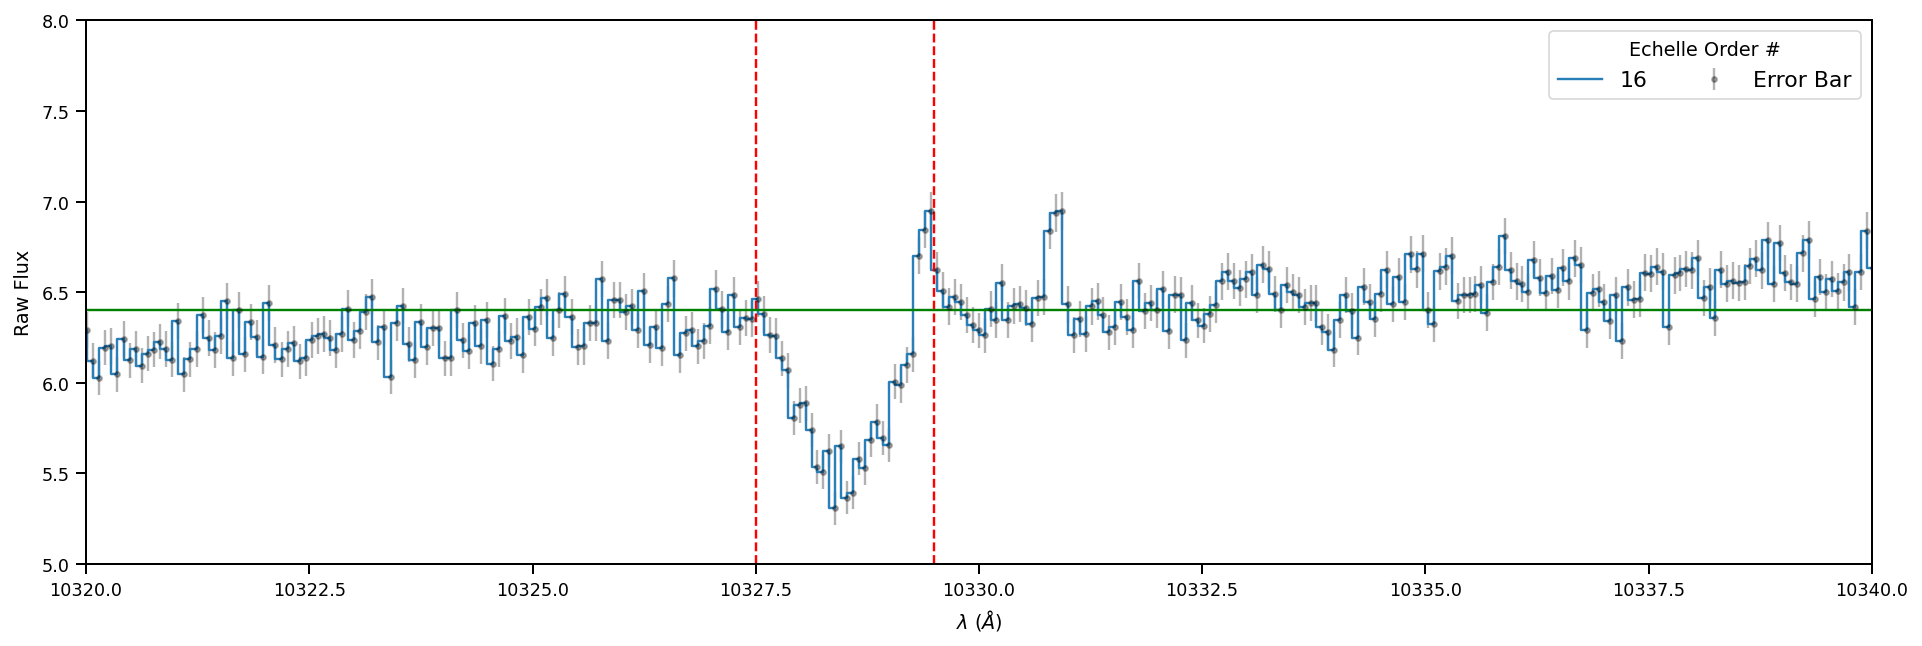

In [46]:
plt.figure(figsize=(16, 5))
order = 16
mask = df.order == order
plt.step(df['Sci Wavl'][mask], df['Sci Flux'][mask], label=order, color='#2980b9');
plt.errorbar(df['Sci Wavl'][mask], df['Sci Flux'][mask], df['Sci Error'][mask], fmt='.', c='k',
             label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(ncol=7, title='Echelle Order #', fontsize=11);
plt.ylim(5,8)
plt.xlim(10320,10340)
wavelength1 = 10327.5
wavelength2 = 10329.5
plt.axvline(wavelength1,linestyle = 'dashed',color = 'red')
plt.axvline(wavelength2,linestyle = 'dashed',color = 'red')
plt.axhline(6.4,color = 'green')

Ok, let's fit a model to this data.  The model will consist of a straight-line trend with a Gaussian subtracted from it.  It will have five parameters, the straight-line trend slope $m$ and offset $b$, and the Gaussian amplitude $A$, center wavelength $\mu$, and width $w$.  
$$f_\lambda(m, b, A, \mu, w)= m \lambda +b - A\cdot e^{-\frac{1}{2} \frac{(\lambda-\mu)^2}{w^2}}$$

Let's focus on the **sub-region** set by the above plot.

In [47]:
sub_region = (df.order == order) & (df['Sci Wavl'] > 10320) & (df['Sci Wavl'] < 10340)
wl = df['Sci Wavl'][sub_region].values
flux = df['Sci Flux'][sub_region].values
unc = df['Sci Error'][sub_region].values

In [48]:
def generative_model(m, b, A, mu, logw, int_wl = 10330):
    """Generate the model given parameters"""
    continuum = m * (wl - int_wl) + b
    w = np.exp(logw)
    gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
    return continuum - gaussian

Let's make an initial guess.

In [55]:
m_guess, b_guess, A_guess, mu_guess, w_guess = 0.01, 6.4, 1.0, 10328.5, np.log(0.4)

In [56]:
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, w_guess)

(5.0, 8.0)

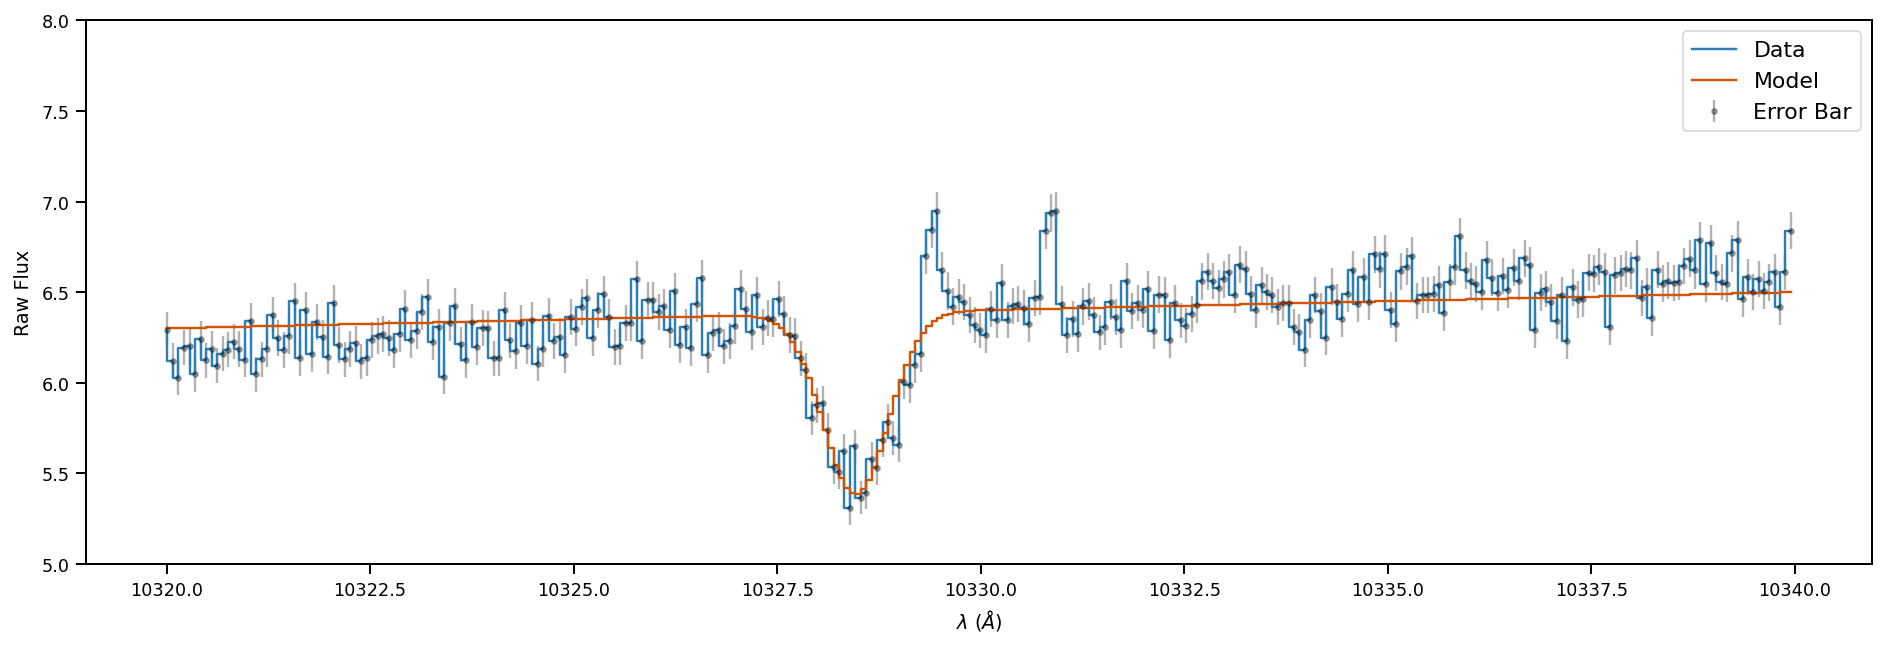

In [57]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(5,8)

The guess is *close* but not perfect-- the line center is slightly off.  That's OK!  Let's use MCMC to fine tune these parameters, and tell us the uncertainty in the parameter values.  We will use [emcee](https://emcee.readthedocs.io/en/stable/).

In [58]:
import emcee

We need to compute the log likelihood of the data, which takes in the parameters and returns a scalar "quality of fit metric".  Here we use *chi squared*, the sum of the squares of the residuals, weighted by their uncertainties.

In [59]:
def log_likelihood(theta):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = 10328.5)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [60]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, w_guess])
log_likelihood(theta_guess)

-318.6222604667861

In [61]:
n_walkers = 32
n_params = 5

In [62]:
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params)

In [63]:
n_steps = 5000

In [64]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 232.64it/s]


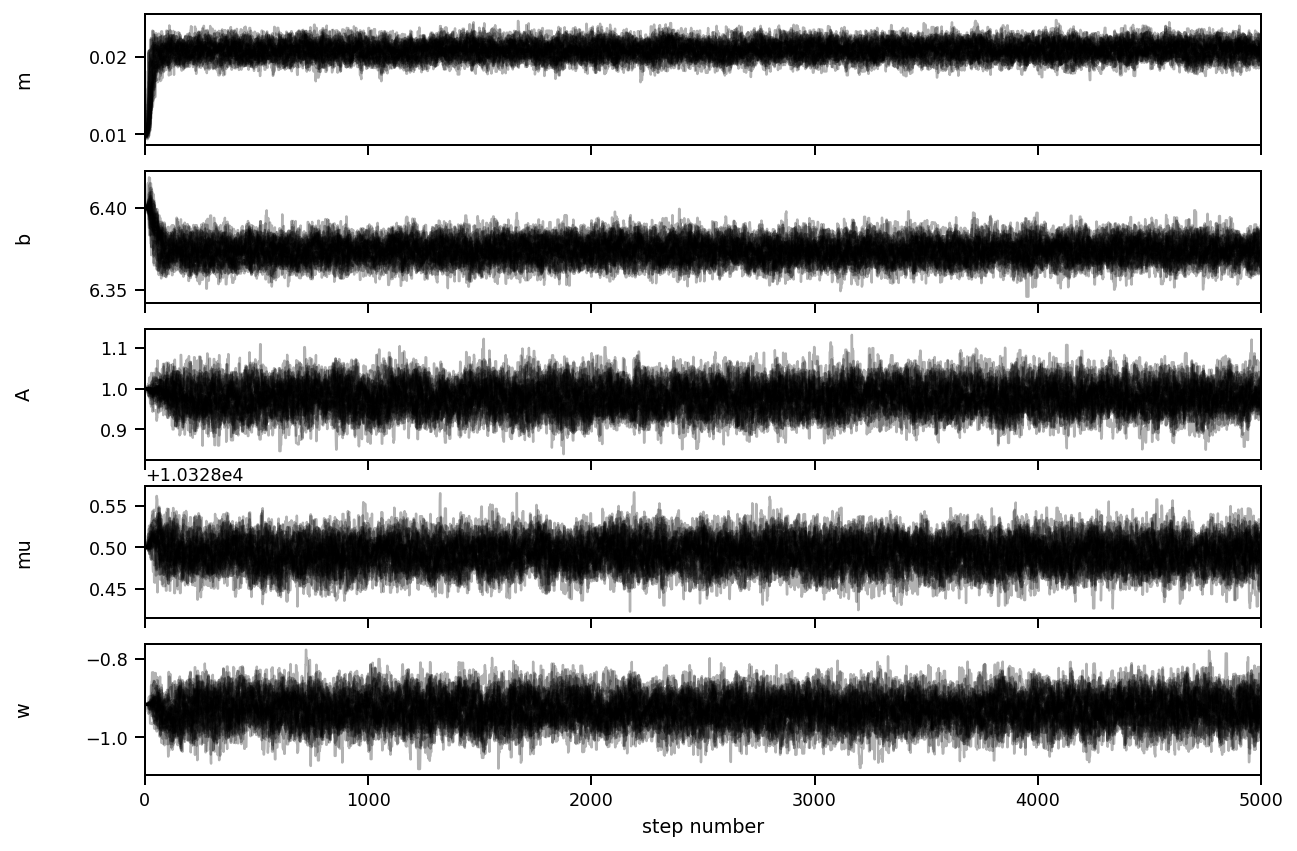

In [65]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [66]:
A_draws = samples[2000:, :, 2].reshape(-1)

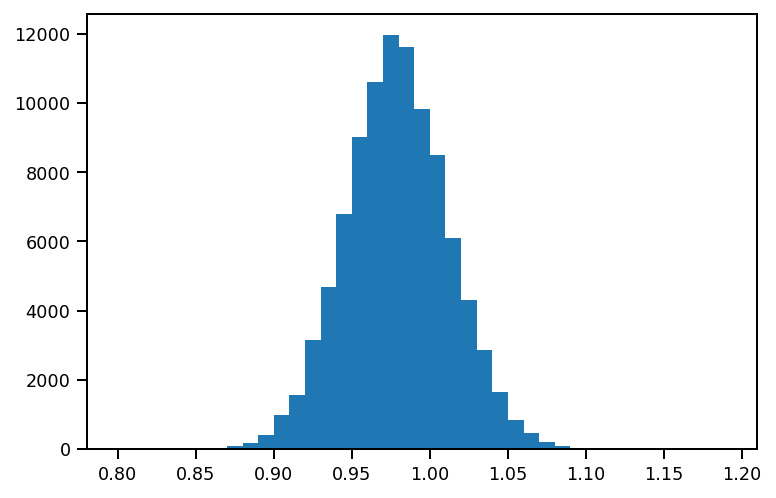

In [67]:
plt.hist(A_draws, bins = np.arange(0.8, 1.2, 0.01));

Let's make a "corner plot" that shows the distribution of parameters.  We can follow the demo on the [emcee tutorial](https://emcee.readthedocs.io/en/stable/tutorials/line/)

In [68]:
flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)

In [69]:
import corner

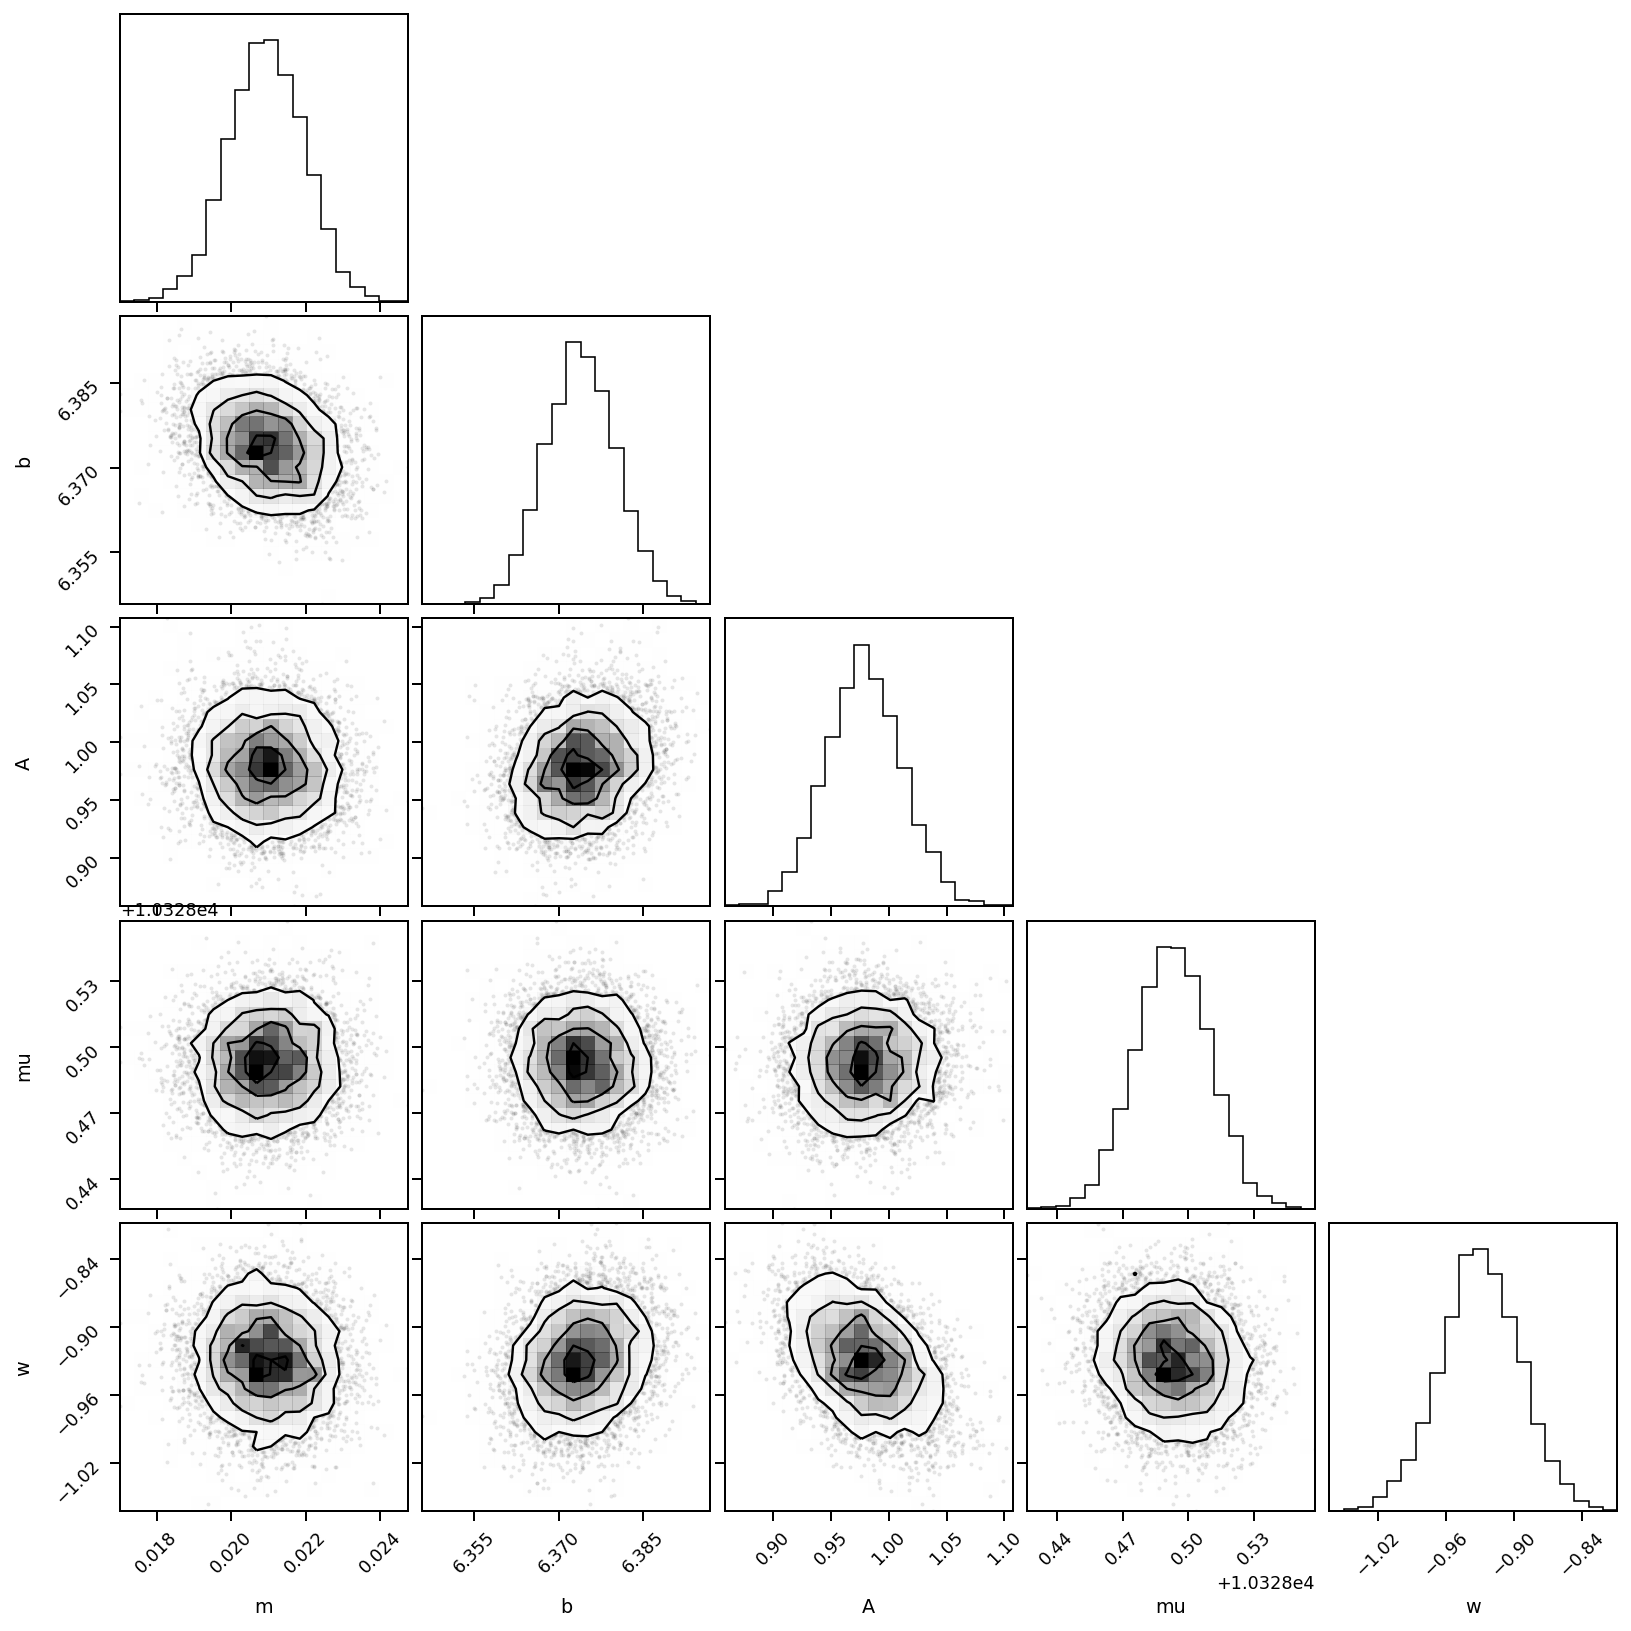

In [70]:
ax = corner.corner(flat_samples, labels=labels)

In [71]:
flat_samples.shape

(6400, 5)

In [72]:
m_fit, b_fit, A_fit, mu_fit, w_fit = flat_samples[3912, :]

In [73]:
good_fit = generative_model(m_fit, b_fit, A_fit, mu_fit, w_fit)

(5.0, 8.0)

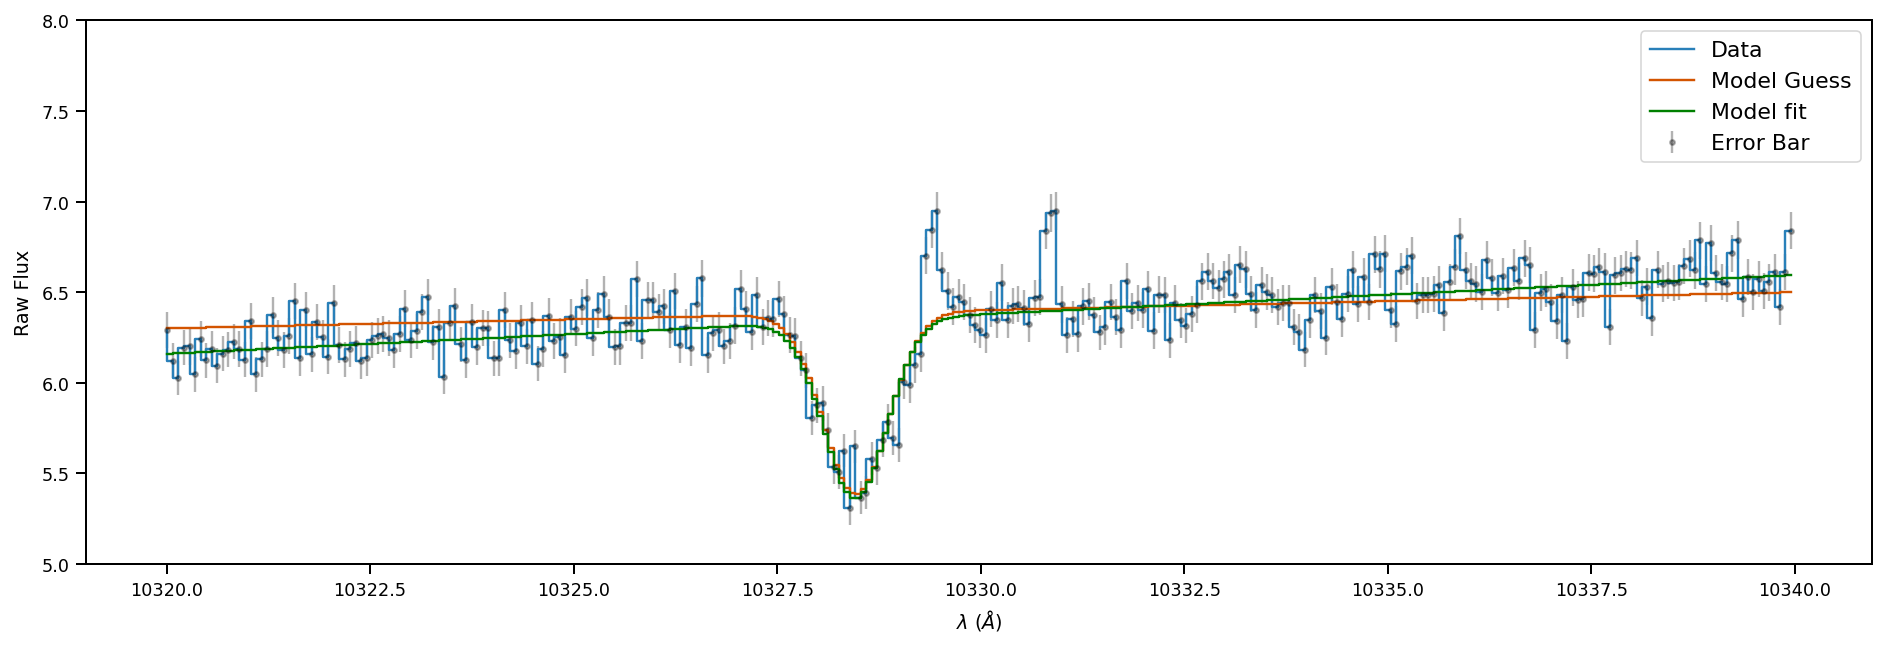

In [74]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model Guess', color='#d35400');
plt.step(wl, good_fit, label='Model fit', color='green');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(5,8)

In [75]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(8512, 5)


In [76]:
ndim = 5

In [77]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [78]:
A_draws = samples[2000:, :, 2].reshape(-1)
b_draws = samples[2000:, :, 1].reshape(-1)
m_draws = samples[2000:, :, 0].reshape(-1)
mu_draws = samples[2000:, :, 3].reshape(-1)
w_draws = np.exp(samples[2000:, :, 4].reshape(-1))

In [79]:
m_fit, b_fit, A_fit, mu_fit, w_fit = flat_samples[3912, :]

In [81]:
good_fit = generative_model(m_fit, b_fit, A_fit, mu_fit, w_fit, int_wl = 10328.5)

(5.0, 8.0)

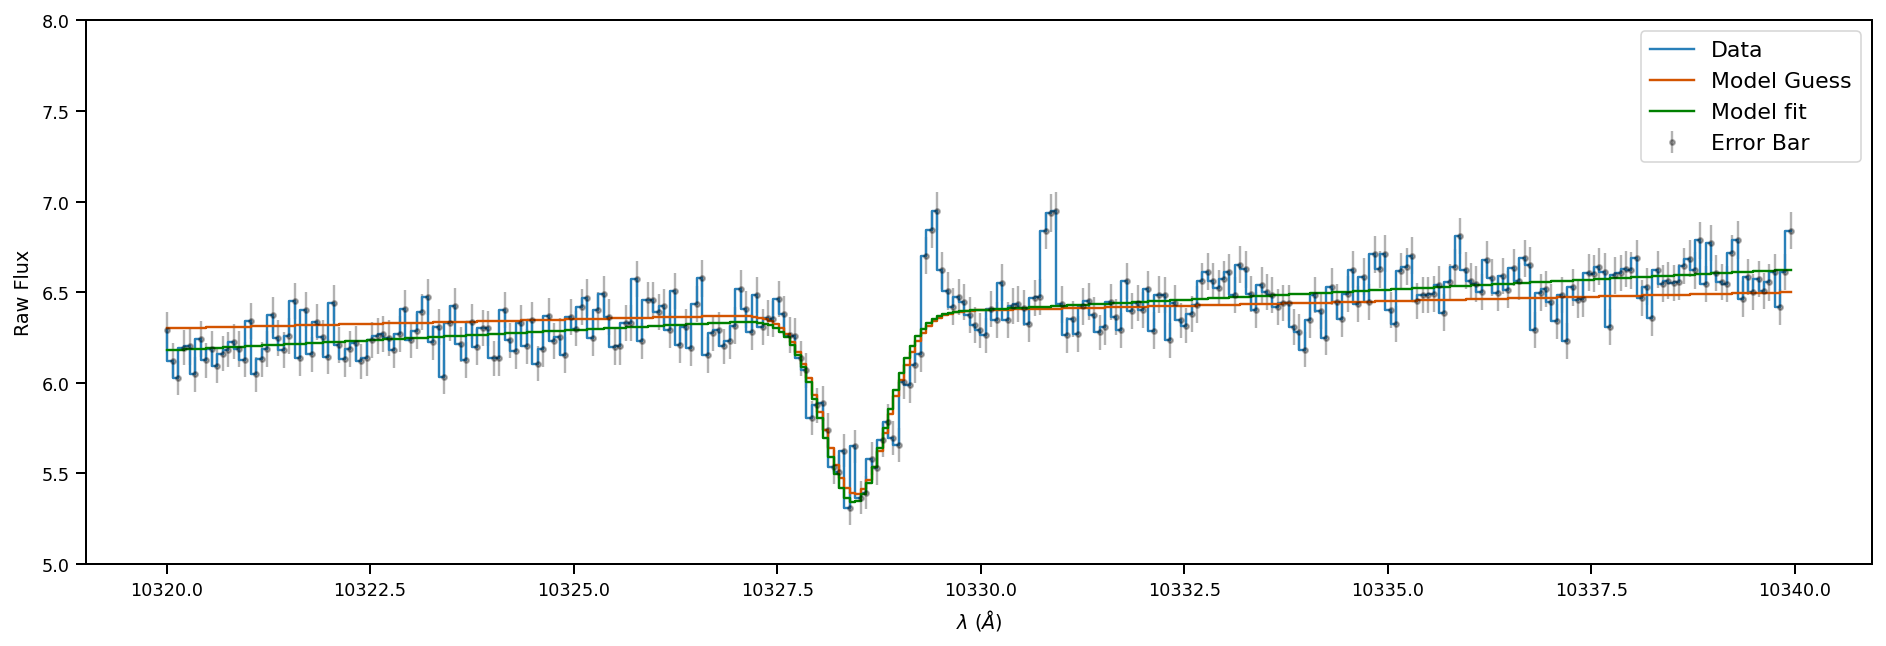

In [82]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.step(wl, flux_guess, label='Model Guess', color='#d35400');
plt.step(wl, good_fit, label='Model fit', color='green');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.ylim(5,8)

In [83]:
EW = ((2*np.pi)**.5)*(A_draws*w_draws)/(m_draws*(mu_draws-10345)+b_draws)
EW

array([0.1632232 , 0.15398298, 0.15970505, ..., 0.15455147, 0.16729582,
       0.16479961])

0.16073660905258413
0.0059036785110967984


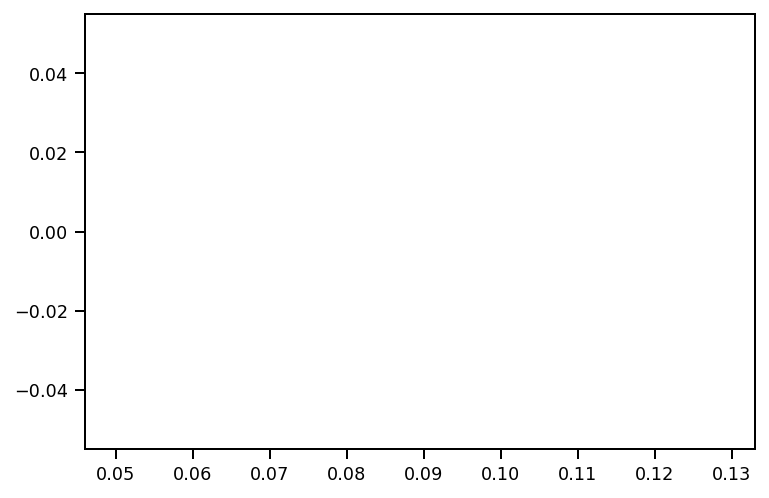

In [84]:
plt.hist(EW, bins = np.arange(0.05, 0.13, 0.001));
ew_mean = np.mean(EW)
ew_std = np.std(EW)
print(ew_mean)
print(ew_std)